## 1.5 Upscaling EOBS then Masking


This notebook builds onto [1.4 Masking](1.4Mask.ipynb), by upscaling EOBS to the SEAS5 grid. We regrid EOBS to the SEAS5 grid so we can select the same grid cells in calculating the UK average for both datasets. The country outline would not be perfect, but the masks would be the same so the comparison would be fair. 

I use the [xesmf package](https://xesmf.readthedocs.io/en/latest/) for upscaling, a good example can be found in this [notebook](https://nbviewer.jupyter.org/github/geoschem/GEOSChem-python-tutorial/blob/master/Chapter03_regridding.ipynb). 

### Import packages

We need the packages regionmask for masking and xesmf for regridding. I cannot install xesmf into the UNSEEN-open environment without breaking my environment, so in this notebook I use a separate 'upscale' environment, as suggested by this [issue](https://github.com/JiaweiZhuang/xESMF/issues/47#issuecomment-582421822). I use the packages esmpy=7.1.0 xesmf=0.2.1 regionmask cartopy matplotlib xarray numpy netcdf4. 

In [1]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [62]:
##import packages
import os
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

import regionmask       # Masking
import xesmf as xe      # Regridding



ModuleNotFoundError: No module named 'seaborn'

In [3]:
##We want the working directory to be the UNSEEN-open directory
pwd = os.getcwd() ##current working directory is UNSEEN-open/Notebooks/1.Download
pwd #print the present working directory

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-trends/Mining'

In [4]:
os.chdir(pwd+'/../') # Change the working directory to UNSEEN-trends
os.getcwd() #print the working directory

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-trends'

## Load SEAS5 ERA5 and EOBS


We retrieve EOBS and ERA5. Then we have to check whether they have to be upscaled to the same grid. Finally, extract the region based on the domain + SEAS5 quantiles.





<xarray.Dataset>
Dimensions:                        (ensemble: 25, leadtime: 4, year: 35)
Coordinates:
  * leadtime                       (leadtime) int64 2 3 4 5
  * ensemble                       (ensemble) int64 0 1 2 3 4 ... 20 21 22 23 24
  * year                           (year) int64 1981 1982 1983 ... 2014 2015
Data variables:
    __xarray_dataarray_variable__  (year, leadtime, ensemble) float64 ...

<xarray.Dataset>
Dimensions:  (lat: 100, lon: 141)
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 34.0 34.25 34.5 34.75 35.0
  * lat      (lat) float64 57.12 57.38 57.62 57.88 ... 81.12 81.38 81.62 81.88
Data variables:
    P_200    (lat, lon) float32 ...

<xarray.Dataset>
Dimensions:                        (ensemble: 25, leadtime: 4, year: 35)
Coordinates:
  * leadtime                       (leadtime) int64 2 3 4 5
  * ensemble                       (ensemble) int64 0 1 2 3 4 ... 20 21 22 23 24
  * year                           (year) int64 1981 1982 1983 ... 2014 2015
Data variables:
    __xarray_dataarray_variable__  (year, leadtime, ensemble) float64 ...

<xarray.Dataset>
Dimensions:                        (time: 62)
Coordinates:
  * time                           (time) int64 1957 1958 1959 ... 2017 2018
Data variables:
    __xarray_dataarray_variable__  (time) float64 ...

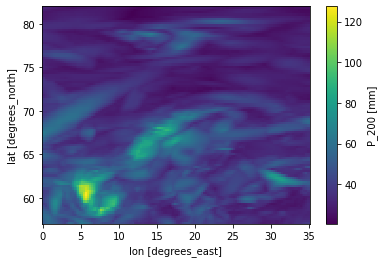

In [5]:
SEAS5_wc = xr.open_dataset('Data/Extremes/Extremes.nc')
SEAS5_wc

SEAS5_q200 = xr.open_dataset('../UNSEEN-trends_play/Quantiles200.nc')
SEAS5_q200

SEAS5_q200['P_200'].plot()

SEAS5_sv = xr.open_dataset('Data/Extremes/Extremes_SV.nc')
SEAS5_sv #Not yet necessary

SeNorge = xr.open_dataset('Data/Extremes/SeNorge.nc')
SeNorge



## ERA5
lets compare to era5

In [6]:
# For Norway
ERA5 = xr.open_dataset('../UNSEEN-trends_play/daysum.Norway.ECMWF_extracted_1981-2019.nc')
ERA5


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 60, lon: 141, time: 14283)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01T15:30:00 ... 2020-01-01T03:30:00
  * lon        (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 34.25 34.5 34.75 35.0
  * lat        (lat) float64 57.12 57.38 57.62 57.88 ... 71.12 71.38 71.62 71.88
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    LSP        (time, lat, lon) float32 ...
    TP         (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Mon Mar 23 11:43:46 2020: cdo mergetime daysum.Arctic.ECMWF...
    institution:  European Centre for Medium-Range Weather Forecasts
    frequency:    day
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [6]:
#For Svalbard 
# ERA5 = xr.open_dataset('../UNSEEN-trends_play/daysum.Arctic.ECMWF_extracted_1981-2018.nc')
# ERA5

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 104, lon: 481, time: 13880)
Coordinates:
  * lon        (lon) float64 -60.0 -59.75 -59.5 -59.25 ... 59.25 59.5 59.75 60.0
  * lat        (lat) float64 63.12 63.38 63.62 63.88 ... 88.12 88.38 88.62 88.88
  * time       (time) datetime64[ns] 1981-01-01T15:30:00 ... 2019-01-01T03:30:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    LSP        (time, lat, lon) float32 ...
    TP         (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Thu Jan 16 09:56:49 2020: cdo daysum Arctic.ECMWF_extracted...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/...

In [7]:
lats= [58,63]# Norway 76,80] #SV
lons=[4,7] #Norway 8,30] #SV 

#The region is selected based on where the climatology (200-year values) are greater than a user-defined threshold
climatology_threshold=90 # for Norway 35 #for SV 

season=[9,10,11] #SON Autumn 

time_event=3 #number of day of the event

In [9]:
ERA5.load()

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 60, lon: 141, time: 14283)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01T15:30:00 ... 2020-01-01T03:30:00
  * lon        (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 34.25 34.5 34.75 35.0
  * lat        (lat) float64 57.12 57.38 57.62 57.88 ... 71.12 71.38 71.62 71.88
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1981-01-01T07:00:00 ... 2020-01-01T07:00:00
    LSP        (time, lat, lon) float32 0.000499414 ... 0.00013829919
    TP         (time, lat, lon) float32 0.002425151 0.0022290235 ... 0.001325039
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Mon Mar 23 11:43:46 2020: cdo mergetime daysum.Arctic.ECMWF...
    institution:  European Centre for Medium-Range Weather Forecasts
    frequency:    day
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [10]:
ERA5_masked = (ERA5
               .sel(lat = slice(lats[0],lats[1]), lon = slice(lons[0],lons[1]))
               .where(SEAS5_q200['P_200']>climatology_threshold)
               .mean(dim=['lat','lon'])
               )
                         
ERA5_masked

<xarray.Dataset>
Dimensions:  (time: 14283)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01T15:30:00 ... 2020-01-01T03:30:00
Data variables:
    LSP      (time) float32 0.0034284748 0.0005938446 ... 0.0015494466
    TP       (time) float32 0.010907733 0.0032492692 ... 0.0019410236

In [11]:
ERA5_masked_extremes = (ERA5_masked
                        .rolling(time = time_event).sum()
                        .sel(time = ERA5_masked['time.season'] == 'SON') #our target events are 3-day events -> convert daily to 3 day cumulative. Remove the NA that result from the rolling window
                        .groupby('time.year')
                        .max(dim = 'time')
                       )
                        
                                  
ERA5_masked_extremes

<xarray.Dataset>
Dimensions:  (year: 39)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2015 2016 2017 2018 2019
Data variables:
    LSP      (year) float32 0.07147303 0.05563388 ... 0.09982152 0.069377914
    TP       (year) float32 0.08243133 0.09767112 ... 0.12371066 0.12706706

<xarray.DataArray '__xarray_dataarray_variable__' (quantile: 5, year: 35)>
array([[ 35.60642898,  22.11630158,  31.30619228,  31.70572594,
         21.10222727,  28.83335948,  31.12767264,  28.60719897,
         29.60581332,  27.39544213,  36.00661084,  27.63822488,
         18.5826458 ,  25.94993822,  31.65870532,  22.16506191,
         25.10860004,  25.60706437,  28.33317965,  30.61165474,
         35.47794372,  24.59408529,  27.76362374,  26.6920086 ,
         26.05447359,  24.33961257,  26.29086934,  25.84769949,
         31.12901188,  31.66748956,  21.81235142,  28.16943079,
         33.5232392 ,  32.56967664,  27.79663913],
       [ 39.97312356,  31.8789368 ,  34.36435517,  35.11098633,
         31.1873734 ,  32.81140858,  32.85021912,  32.84925185,
         34.38879931,  32.93500757,  37.71644682,  33.32070615,
         30.0215154 ,  28.17864991,  36.89160999,  34.25769676,
         34.37365452,  34.5576481 ,  35.72014235,  35.36170777,
         38.52405138,  32.01423804,  34.09400918,  31.8577575 ,
         35.1554363 ,  33.14466588,  33.5966289 ,  34.18496419,
         35.30888055,  39.13361896,  30.44977961,  32.29896873,
         34.89966458,  34.40980129,  33.55103442],
       [ 56.08932115,  56.05841801,  56.31229095,  55.60849607,
         54.60897647,  53.46024036,  55.31615019,  58.68338048,
         56.54992349,  56.84881285,  59.37717669,  52.69095302,
         56.74413219,  53.82975936,  58.32864903,  54.51176316,
         52.47127824,  55.58392592,  57.35242553,  58.46551992,
         61.00923195,  52.46042088,  55.83389662,  57.32432939,
         59.98071283,  56.22881278,  59.38083306,  57.37239122,
         60.84578298,  54.22957614,  53.71040292,  55.5497501 ,
         58.72515403,  56.27357401,  52.91648954],
       [ 92.86091533,  98.21036663,  87.72000968,  90.46698324,
         92.10375696,  98.52336012,  89.8710791 , 100.42274483,
         98.72209933,  95.62209118,  89.68340904,  95.57417352,
         92.03279875,  90.72985984,  94.01296657,  92.08968449,
        105.96109685, 102.53032241,  97.28608243, 103.62379774,
         93.13219097,  90.54944385,  88.34082671, 100.65039564,
         94.50724255, 106.31113742,  99.07319527,  99.79615789,
         92.5214719 ,  92.03247894,  86.60473339,  92.29080919,
         97.2846074 ,  98.30655102,  91.96054731],
       [103.80271077, 110.56178808, 105.32357544, 114.90122229,
         99.21236336, 123.35827202,  94.28172559, 106.90949112,
        108.76336694, 107.99846798, 105.37230223, 114.22271281,
        105.37586361, 105.91676831, 122.34155089,  98.11047465,
        132.24962354, 114.25339431, 108.28705132, 122.73956835,
        103.35408896, 113.33077401,  99.73534942, 111.05775088,
        107.60662705, 116.40907079, 116.19322747, 102.03292221,
        132.1914345 , 109.55557972,  96.86486423, 119.49183047,
        133.9815557 , 108.9809984 ,  97.2353369 ]])
Coordinates:
  * year      (year) int64 1981 1982 1983 1984 1985 ... 2011 2012 2013 2014 2015
  * quantile  (quantile) float64 0.0 0.025 0.5 0.975 1.0

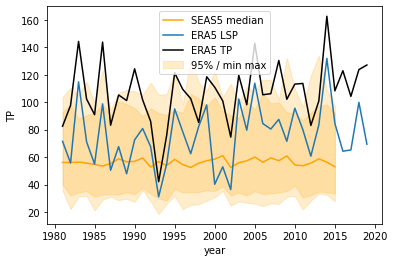

In [23]:
ax = plt.axes()

Quantiles = SEAS5_wc['__xarray_dataarray_variable__'].quantile([0,2.5/100, 0.5, 97.5/100,1], dim=['ensemble','leadtime'])
Quantiles
ax.plot(Quantiles.year, Quantiles.sel(quantile=0.5), color='orange',label = 'SEAS5 median')
ax.fill_between(Quantiles.year.values, Quantiles.sel(quantile=0.025), Quantiles.sel(quantile=0.975), color='orange', alpha=0.2,label = '95% / min max')
ax.fill_between(Quantiles.year.values, Quantiles.sel(quantile=0), Quantiles.sel(quantile=1), color='orange', alpha=0.2)


(ERA5_masked_extremes['LSP']*1000).plot(label = 'ERA5 LSP')
(ERA5_masked_extremes['TP']*1000).plot(color='black', label = 'ERA5 TP')

# EOBS_regridded_masked_extremes.plot(color = 'black', label='EOBS')
# SeNorge['__xarray_dataarray_variable__'].plot(label='SeNorge')
plt.legend()

Text(0, 0.5, 'Three-day precipitation (mm)')

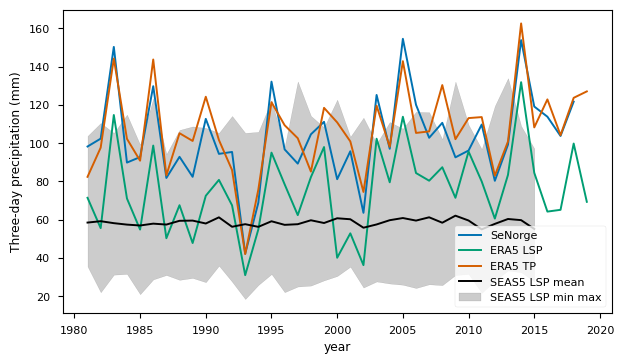

In [71]:
plt.style.use(['default','seaborn-colorblind','seaborn-paper'])
# plt.rcParams['fontname'] = 'Arial'
# matplotlib.rc['font.family'] = 'sans-serif'
# matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

fig, ax = plt.subplots(figsize=(180/25.4, 100/25.4))

# Quantiles = SEAS5_wc['__xarray_dataarray_variable__'].quantile([0,2.5/100, 0.5, 97.5/100,1], dim=['ensemble','leadtime'])
# Quantiles
# ax.plot(Quantiles.year, Quantiles.sel(quantile=0.5), color='orange',label = 'SEAS5 median')
# ax.fill_between(Quantiles.year.values, Quantiles.sel(quantile=0.025), Quantiles.sel(quantile=0.975), color='orange', alpha=0.2,label = '95% / min max')
# ax.fill_between(Quantiles.year.values, Quantiles.sel(quantile=0), Quantiles.sel(quantile=1), color='orange', alpha=0.2)


# EOBS_regridded_masked_extremes.plot(color = 'black', label='EOBS')
SeNorge['__xarray_dataarray_variable__'].sel(time = slice ('1981', '2020')).plot(label='SeNorge')
(ERA5_masked_extremes['LSP']*1000).plot(label = 'ERA5 LSP')
(ERA5_masked_extremes['TP']*1000).plot(label = 'ERA5 TP')
SEAS5_wc['__xarray_dataarray_variable__'].mean(dim=['ensemble','leadtime']).plot(label = 'SEAS5 LSP mean', color = 'black')
ax.fill_between(SEAS5_wc.year.values, SEAS5_wc['__xarray_dataarray_variable__'].min(dim=['ensemble','leadtime']), SEAS5_wc['__xarray_dataarray_variable__'].max(dim=['ensemble','leadtime']), color='black', alpha=0.2,label = 'SEAS5 LSP min max')

plt.ylabel('Three-day precipitation (mm)')
plt.legend(loc ='best')
# plt.savefig('graphs/ERA5_SEAS5_lsp.png', dpi=300, transparent=False)

In [69]:
matplotlib.rcParams['font.sans-serif']
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# I have no Helvetica!

['Helvetica']

Matplotlib is building the font cache using fc-list. This may take a moment.


['/usr/share/fonts/truetype/adf/UniversalisADFCdStd-Regular.otf',
 '/usr/share/fonts/truetype/gentium-basic/GenBkBasBI.ttf',
 '/usr/share/fonts/truetype/ebgaramond/EBGaramond-InitialsF1.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf',
 '/usr/share/fonts/opentype/lobster/lobster.otf',
 '/usr/share/fonts/opentype/linux-libertine/LinBiolinum_RI.otf',
 '/usr/share/fonts/truetype/gentium-basic/GenBasBI.ttf',
 '/usr/share/fonts/opentype/stix/STIXSizeThreeSym-Regular.otf',
 '/usr/share/fonts/truetype/lato/Lato-HeavyItalic.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-BoldOblique.ttf',
 '/usr/share/fonts/truetype/ttf-dejavu/DejaVuSerif-BoldItalic.ttf',
 '/usr/share/fonts/opentype/stix/STIXIntegralsSm-Bold.otf',
 '/usr/share/fonts/truetype/lato/Lato-Medium.ttf',
 '/usr/share/fonts/truetype/lyx/msam10.ttf',
 '/usr/share/fonts/truetype/freefont/FreeSansOblique.ttf',
 '/usr/share/fonts/opentype/stix/STIXIntegralsUpSm-Regular.otf',
 '/usr/share/fonts

In [60]:
SeNorge['__xarray_dataarray_variable__'].sel(time = slice ('1981', '2015')).mean()/SEAS5_wc['__xarray_dataarray_variable__'].mean()
(ERA5_masked_extremes['TP'].sel(year = slice ('1981', '2015')).mean()*1000)/SEAS5_wc['__xarray_dataarray_variable__'].mean()
(ERA5_masked_extremes['LSP'].sel(year = slice ('1981', '2015')).mean()*1000)/SEAS5_wc['__xarray_dataarray_variable__'].mean()

<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(1.74074292)

<xarray.DataArray ()>
array(1.79898902)

<xarray.DataArray ()>
array(1.28734379)

In [19]:
ERA5_masked_extremes.to_netcdf('Data/ERA5_sv.nc')

In [20]:
ERA5_masked_extremes_df = ERA5_masked_extremes.to_dataframe()*1000
ERA5_masked_extremes_df.head()
ERA5_masked_extremes_df.to_csv('Data/ERA5_sv.csv')

,LSP,TP
year,,
1981,22.329264,24.611040
1982,18.013126,19.020597
1983,22.054308,28.056074
1984,22.662945,24.590832
1985,16.631464,17.513182


In [33]:
(SeNorge.rename({'__xarray_dataarray_variable__': 'precipitation'})
 .to_dataframe()
 .to_csv('Data/SeNorge.csv')
)

In [34]:
(SEAS5_wc.rename({'__xarray_dataarray_variable__': 'precipitation'})
 .to_dataframe()
 .to_csv('Data/SEAS5_wc.csv')
)

### Pandas dataframe for time of event



In [17]:
ERA5_df = ERA5_masked.rolling(time = time_event).sum().sel(time = ERA5_masked['time.season'] == 'SON').to_dataframe()
ERA5_df['year'] = ERA5_df.index.year
ERA5_df

idx = ERA5_df.groupby('year')['LSP'].transform(max) == ERA5_df['LSP']
ERA5_df = ERA5_df[idx]
ERA5_df 
# = ERA5_masked.assign_coords({'time_': ERA5_masked['time']})
# ERA5_masked


,LSP,TP,year
time,,,
1981-09-01 11:30:00,0.009193,0.009282,1981
1981-09-02 11:30:00,0.007156,0.008284,1981
1981-09-03 11:30:00,0.010787,0.012244,1981
1981-09-04 11:30:00,0.014935,0.016689,1981
1981-09-05 11:30:00,0.022329,0.024611,1981
...,...,...,...
2018-11-26 11:30:00,0.002023,0.003607,2018
2018-11-27 11:30:00,0.009465,0.011256,2018
2018-11-28 11:30:00,0.011351,0.013621,2018


,LSP,TP,year
time,,,
1981-09-05 11:30:00,0.022329,0.024611,1981
1982-11-11 11:30:00,0.018013,0.019021,1982
1983-09-25 11:30:00,0.022054,0.028056,1983
1984-10-08 11:30:00,0.022663,0.024591,1984
1985-10-02 11:30:00,0.016631,0.017513,1985
1986-10-14 11:30:00,0.024275,0.025844,1986
1987-10-12 11:30:00,0.017883,0.017930,1987
1988-10-18 11:30:00,0.017913,0.018278,1988
1989-09-27 11:30:00,0.024939,0.027922,1989


## EOBS

In [62]:
EOBS = xr.open_dataset('../UK_example/EOBS/rr_ens_mean_0.25deg_reg_v20.0e.nc') ## open the data
EOBS = EOBS.sel(time = slice('1957','2018'), latitude = slice(55,83), longitude = slice (0, 35)) # same as SeNorge
EOBS

<xarray.Dataset>
Dimensions:    (latitude: 82, longitude: 140, time: 22645)
Coordinates:
  * latitude   (latitude) float64 55.12 55.38 55.62 55.88 ... 74.88 75.12 75.38
  * longitude  (longitude) float64 0.125 0.375 0.625 0.875 ... 34.38 34.62 34.88
  * time       (time) datetime64[ns] 1957-01-01 1957-01-02 ... 2018-12-31
Data variables:
    rr         (time, latitude, longitude) float32 ...
Attributes:
    E-OBS_version:  20.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Tue Sep 24 12:18:37 2019: ncks -O -d time,0,25413 /data4/...
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....

This is the daily precipitation within EOBS. We start by extracting the domain for the West Coast (WC) and Svalbard (SV) domains 

In [27]:
regridder = xe.Regridder(EOBS.rename({'longitude': 'lon', 'latitude': 'lat'}), SEAS5_wc_q200,'bilinear')


Create weight file: bilinear_82x140_100x141.nc


Now that we have the regridder, we can apply the regridder to our EOBS dataarray:

In [29]:
EOBS_regridded = regridder(EOBS['rr'])
EOBS_regridded

<xarray.DataArray 'rr' (time: 22645, lat: 100, lon: 141)>
array([[[0.00000000e+00,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00,            nan,            nan, ...,
         2.55001250e+00, 2.35002489e+00, 0.00000000e+00],
        [0.00000000e+00,            nan,            nan, ...,
         2.45002481e+00, 2.39998771e+00, 0.00000000e+00],
        [0.00000000e+00,            nan,            nan, ...,
         2.40001231e+00, 2.30002462e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       ...,

       [[0.00000000e+00,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00,            nan,            nan, ...,
         1.40007457e+00, 1.35009948e+00, 0.00000000e+00],
        [0.00000000e+00,            nan,            nan, ...,
         1.30002484e+00, 1.25002483e+00, 0.00000000e+00],
        [0.00000000e+00,            nan,            nan, ...,
         1.15003703e+00, 1.20001238e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00,            nan,            nan, ...,
         1.24322818e-05, 2.48645637e-05, 0.00000000e+00],
        [0.00000000e+00,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.000

In [43]:
lats= [58,63]# SV[76,80]
lons=[4,7] #SV[8,30]

#The region is selected based on where the climatology (200-year values) are greater than a user-defined threshold
climatology_threshold=90 #35 for SV

season=[9,10,11] #SON Autumn 

time_event=3 #number of day of the event

### illustrate before and after regridding
We plot the raw EOBS data, the regridded EOBS data and the SEAS5 mask. 
We need to do the regridding so we can apply the SEAS5 mask

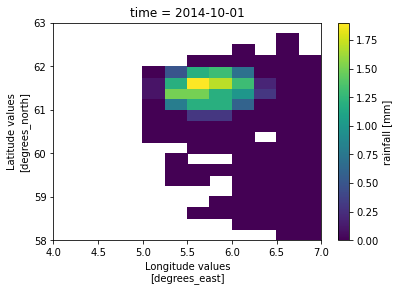

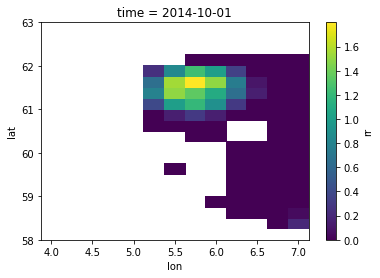

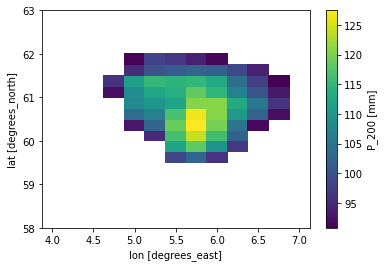

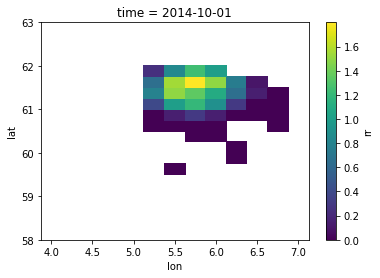

In [52]:
EOBS['rr'].sel(time='2014-10-01', latitude = slice(lats[0],lats[1]), longitude = slice(lons[0],lons[1])).plot()
plt.show()
EOBS_regridded.sel(time='2014-10-01', lat = slice(lats[0],lats[1]), lon = slice(lons[0],lons[1])).plot()
plt.show()
SEAS5_wc_q200['P_200'].sel(lat = slice(lats[0],lats[1]), lon = slice(lons[0],lons[1])).where(SEAS5_wc_q200['P_200']>climatology_threshold).plot()
plt.show()
EOBS_regridded.sel(time='2014-10-01', lat = slice(lats[0],lats[1]), lon = slice(lons[0],lons[1])).where(SEAS5_wc_q200['P_200']>climatology_threshold).plot()


In [88]:
EOBS_regridded_masked = (EOBS_regridded
                         .sel(lat = slice(lats[0],lats[1]), lon = slice(lons[0],lons[1]))
                         .where(SEAS5_wc_q200['P_200']>climatology_threshold)
                         .mean(dim=['lat','lon'])
                        )
                         
EOBS_regridded_masked

<xarray.DataArray 'rr' (time: 22645)>
array([ 0.        ,  0.        ,  0.        , ...,  6.23776454,
        9.39834257, 17.33428703])
Coordinates:
  * time     (time) datetime64[ns] 1957-01-01 1957-01-02 ... 2018-12-31

In [ ]:
EOBS_regridded_masked_extremes = (EOBS_regridded_masked
                                  .rolling(time=3).sum().dropna('time')
                                  .sel(time = EOBS_regridded_masked['time.season'][2:] == 'SON') #our target events are 3-day events -> convert daily to 3 day cumulative. Remove the NA that result from the rolling window
                                  .groupby('time.year')
                                  .max(dim='time')
                                  )
                                  
EOBS_regridded_masked_extremes